# Stock Price Prediction with ARCH and ARIMA

**Kyu Cho  
October 17, 2016**

# Table of Contents

1. Data Exploration
2. Estimating & Eliminating Trend
    - Stationarity Test
3. Build ARIMA with Hypertuning Parameters
4. ARIMA Prediction
5. Autocorrelation Found in the Squares of the Residuals
6. Build ARCH and GARCH with Hypertuning Parameters
7. ARCH Prediction

# 1. Data Exploration

In [1]:
import os
os.chdir('C:\Users\Kyu\Google Drive\Portfolio\project 108')
from IPython.display import display

import matplotlib.pyplot as plt
from matplotlib.pyplot import acorr
plt.style.use('fivethirtyeight')
%matplotlib inline

import pandas as pd
from pandas.tools.plotting import autocorrelation_plot

import numpy as np
import seaborn as sns
import datetime
import sys
import quandl

import statsmodels
import statsmodels.stats.diagnostic as diag
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats.mstats import normaltest
from arch import arch_model

In [2]:
# load data
ENOC = quandl.get("YAHOO/ENOC")
ENOC.to_csv('ENERNOC.csv')

lastENOC = ENOC[-1:]
ENOC = ENOC[:-1]

In [3]:
display(ENOC.shape)
display(ENOC.head(3))
display(ENOC.tail(3))
display(ENOC.describe())
display(ENOC.info())

# check factor variable levels
display("Checking factor variable levels")
display(ENOC.apply(lambda x: len(x.unique())))

(2370, 6)

,Open,High,Low,Close,Volume,Adjusted Close
Date,,,,,,
2007-05-18,30.76,32.480000,30.16,31.129999,4177000.0,31.129999
2007-05-21,31.07,32.000000,31.00,32.000000,446800.0,32.000000
2007-05-22,32.25,34.700001,32.00,33.750000,337600.0,33.750000


,Open,High,Low,Close,Volume,Adjusted Close
Date,,,,,,
2016-10-11,5.34,5.36,5.29,5.34,149300.0,5.34
2016-10-12,5.32,5.33,5.17,5.20,66900.0,5.20
2016-10-13,5.14,5.23,5.14,5.21,114700.0,5.21


,Open,High,Low,Close,Volume,Adjusted Close
count,2370.000000,2370.000000,2370.000000,2370.000000,2.370000e+03,2370.000000
mean,17.729152,18.158675,17.256983,17.690494,3.320659e+05,17.690494
std,10.109172,10.312520,9.861551,10.084535,4.884559e+05,10.084535
min,3.200000,3.250000,2.920000,3.150000,0.000000e+00,3.150000
25%,9.775000,10.040000,9.470000,9.750000,1.571500e+05,9.750000
50%,15.680000,15.985000,15.270000,15.645000,2.435500e+05,15.645000
75%,23.577500,24.000000,22.850000,23.527501,3.725750e+05,23.527501
max,49.919998,50.500000,48.830002,49.990002,1.596730e+07,49.990002


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2370 entries, 2007-05-18 to 2016-10-13
Data columns (total 6 columns):
Open              2370 non-null float64
High              2370 non-null float64
Low               2370 non-null float64
Close             2370 non-null float64
Volume            2370 non-null float64
Adjusted Close    2370 non-null float64
dtypes: float64(6)
memory usage: 129.6 KB


None

'Checking factor variable levels'

Open              1585
High              1617
Low               1573
Close             1635
Volume            1889
Adjusted Close    1635
dtype: int64

# 2. Estimating & Eliminating Trend

**log transformation** : Penalize higher values more than smaller values.
- log(called logENOC) ensures that level induced volatility does not interfere with the stationarity of the data. 

- Logging the series prevents overall changes in volume from distorting the behavior of the stock.

In [4]:
ENOC['date']= ENOC.index
ENOC['ENOC']= ENOC.Close
ENOC['logENOC']= np.log(ENOC['ENOC'])

**Differencing** : taking the differece with a particular time lag.
- Take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity.

In [5]:
ENOC['diflogENOC'] = ENOC['logENOC'] - ENOC['logENOC'].shift(periods=-1)
ENOC = ENOC.dropna()

## Plot

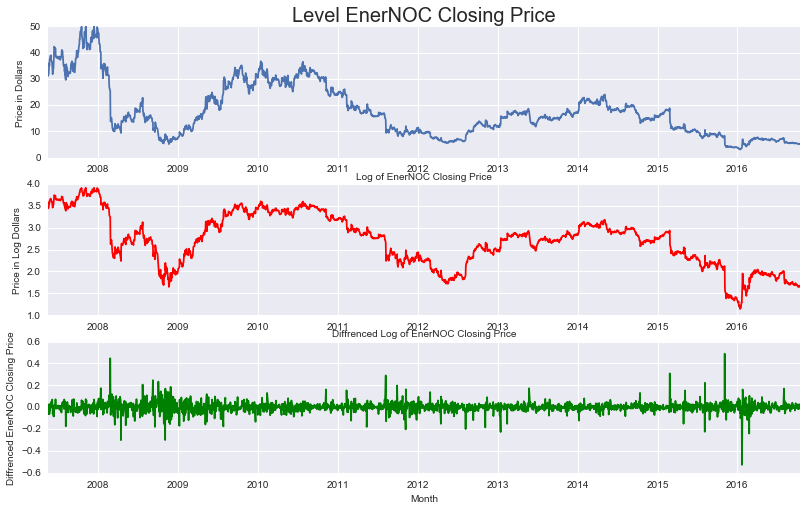

In [6]:
fig, ax = plt.subplots(figsize=(12,8))

plt.subplot(3, 1, 1)
plt.plot(ENOC.date, ENOC.ENOC, label = "Log of EnerNOC Closing Price")
plt.title("Level EnerNOC Closing Price", size=20,)
plt.ylabel("Price in Dollars", size = 10)

plt.subplot(3, 1, 2)
plt.plot(ENOC.date, ENOC.logENOC, label = 'Log of EnerNOC', color='r')
plt.title("Log of EnerNOC Closing Price", size=10,)
plt.ylabel("Price in Log Dollars", size=10)

plt.subplot(3, 1, 3)
plt.plot(ENOC.date, ENOC.diflogENOC, label = '1st Diffrence of Log of EnerNOC', color='g')
plt.title("Diffrenced Log of EnerNOC Closing Price", size=10,)
plt.ylabel("Diffrenced EnerNOC Closing Price", size=10)
plt.xlabel('Month', size=10)

- The level closing price and the log of the level closing price are not mean reverting and are therefore not stationary. 
- The difference of the closing price, the stock returns, do look stationary.


## Plot

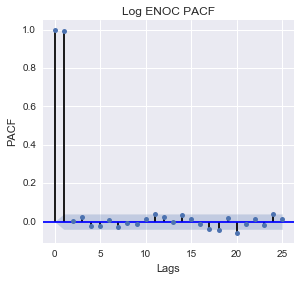

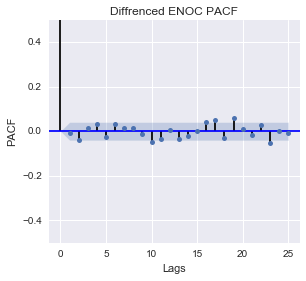

In [7]:
fig, ax = plt.subplots(figsize=(4,4))
plot_pacf(ENOC.logENOC, lags=25, ax=ax)
ax.set_title('Log ENOC PACF')
ax.set_xlabel('Lags')
ax.set_ylabel('PACF')

fig, ax = plt.subplots(figsize=(4,4))
plot_pacf(ENOC.diflogENOC, lags=25, ax=ax)
ax.set_title('Diffrenced ENOC PACF')
ax.set_ylim(-.5, .5)
ax.set_xlabel('Lags')
ax.set_ylabel('PACF')

When one plots the partial autocorrelation function for each type of data, the log shows clear partial autocorrelation, while the differenced value does not.

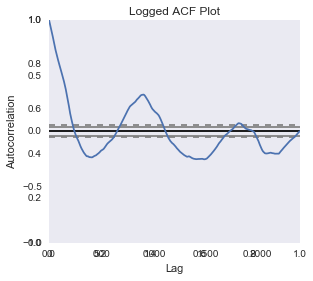

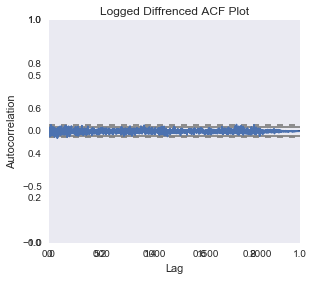

In [8]:
fig, ax = plt.subplots(figsize=(4,4))
ax = autocorrelation_plot(ENOC.logENOC)
ax.set_title('Logged ACF Plot')

fig, ax = plt.subplots(figsize=(4,4))
ax = autocorrelation_plot(ENOC.diflogENOC)
ax.set_title('Logged Diffrenced ACF Plot')

### Stationarity Test

In [9]:
#Perform Dickey-Fuller test:
print 'Results of Dickey-Fuller Test:'
dftest = adfuller(ENOC.diflogENOC, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print dfoutput

Results of Dickey-Fuller Test:
Test Statistic                -1.006260e+01
p-value                        1.321406e-17
# Lags Used                    2.200000e+01
Number of Observations Used    2.346000e+03
Critical Value (5%)           -2.862773e+00
Critical Value (1%)           -3.433140e+00
Critical Value (10%)          -2.567426e+00
dtype: float64


- The real statistical test of stationarity, the Dickey-Fuller test, yields a very small P-value for the differenced time series proving that it is indeed stationary.

# 3. Build ARIMA with Hypertuning Parameters

In [10]:
p = 0
q = 0
d = 1
pdq = []
aic = []
ararray = (ENOC.logENOC.dropna().as_matrix())

for p in range(3):
    for q in range(3):
        try:
            model = ARIMA(ararray, (p,d,q)).fit()
            x = model.aic
            x1 = (p,d,q)
            
            print (x1, x)
            aic.append(x)
            pdq.append(x1)
        except:
            pass
            
keys = pdq
values = aic
d = dict(zip(keys, values))
minaic = min(d, key=d.get)

for i in range(3):
    p = minaic[0]
    d = minaic[1]
    q = minaic[2]
print "Best Model is :", (p,d,q)
ARIMIAmod = ARIMA(ararray, (p,d,q)).fit()

((0, 1, 0), -7761.4492640361732)
((0, 1, 1), -7759.543721739879)


C:\Users\Kyu\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


((0, 1, 2), -7760.994466015858)
((1, 1, 0), -7759.536264524668)
((2, 1, 0), -7761.251540763726)
((2, 1, 1), -7759.421747179076)
Best Model is : (0, 1, 0)


C:\Users\Kyu\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Using Python’s stats model package, and various parameters of an ARIMA (Auto-Regressive-Integrated-Moving-Average) model are thrown at the data. The model with the lowest Akaike Information Criterion (AIC) a measure of how probable the model’s explanatory power, is selected as the most accurate.  
Here the AIRAM model used a p=2, d =1, q= 0.

In [11]:
pd.DataFrame(zip(pdq, aic)).to_csv("ENERNOCarima.csv")

The model is then used to predict values at each step of the series. The difference between these values and the actual time series is found and squared. This is the square error in the model.

In [12]:
# remove shipfted value
ENOC = ENOC[1:] 
ENOC = ENOC.reset_index()

ENOC['predict'] = ARIMIAmod.predict()
ENOC['errors'] = ENOC.diflogENOC - ENOC.predict
ENOC['sqrError'] = ENOC.errors**2

# 4. ARIMA Prediction

- The model is used to forecast a number of steps ahead. This also produces a 95% confidence interval for this prediction.

In [13]:
numofsteps = 1
stepahead = ARIMIAmod.forecast(numofsteps)[0]
ferrors = ARIMIAmod.forecast(numofsteps)[2]
ferrors
print '%s Steps Ahead Forecast Value is:' % numofsteps, np.exp(stepahead)
print '%s Steps Ahead 95 percent CI is:' % numofsteps, np.exp(ferrors[0])
print 'Most Recent EnerNOC Close: %s' % (lastENOC.Close)

1 Steps Ahead Forecast Value is: [ 5.19607181]
1 Steps Ahead 95 percent CI is: [ 4.73923733  5.69694244]
Most Recent EnerNOC Close: Date
2016-10-14    5.16
Name: Close, dtype: float64


- The prediction at first seems reasonable. However, on closer inspection the squared residuals show autocorrelation!

# 5. Autocorrelation Found in the Squares of the Residuals

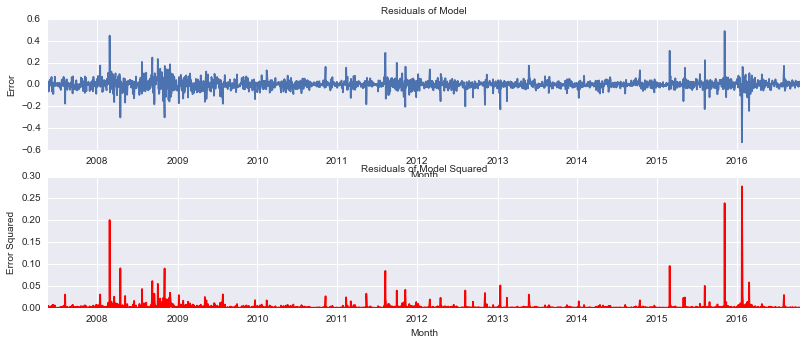

In [14]:
fig, ax = plt.subplots(figsize=(12,8))

plt.subplot(3, 1, 1)
plt.plot(ENOC.Date, ENOC.errors, label="Residual")
plt.title("Residuals of Model", size=10,)
plt.ylabel("Error", size=10)
plt.xlabel('Month', size=10)

plt.subplot(3, 1, 2)
plt.plot(ENOC.Date, ENOC.sqrError, label='Residual Squared', color='r')
plt.title("Residuals of Model Squared", size=10,)
plt.ylabel("Error Squared", size=10)
plt.xlabel('Month', size=10)

(0, 25)

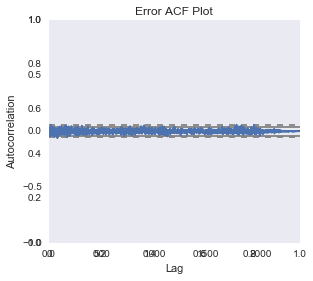

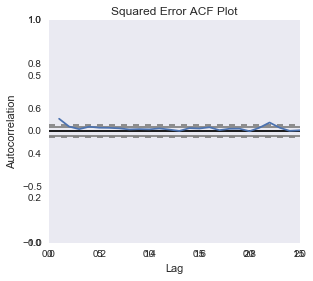

In [15]:
fig, ax = plt.subplots(figsize=(4,4))
ax = autocorrelation_plot(ENOC.errors)
ax.set_title('Error ACF Plot')

fig, ax = plt.subplots(figsize=(4,4))
ax = autocorrelation_plot(ENOC.sqrError)
ax.set_title('Squared Error ACF Plot')
ax.set_xlim(0,25)

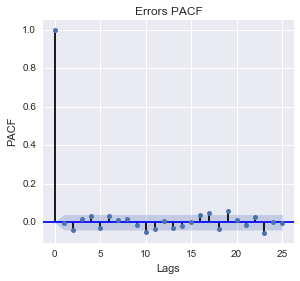

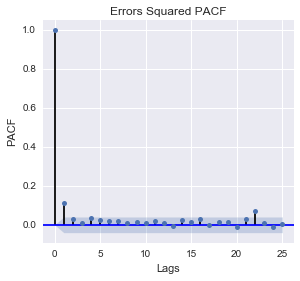

In [16]:
fig, ax = plt.subplots(figsize=(4,4))
plot_pacf(ENOC.errors, lags=25, ax=ax)
ax.set_title('Errors PACF')
ax.set_xlabel('Lags')
ax.set_ylabel('PACF')

fig, ax = plt.subplots(figsize=(4,4))
plot_pacf(ENOC.sqrError, lags=25, ax=ax)
ax.set_title('Errors Squared PACF')
#ax.set_ylim(-.5, .5)
ax.set_xlabel('Lags')
ax.set_ylabel('PACF')

- The residuals showed little to no autocorrelation or partial autocorrelation. 
    + This is expected. The squares of the residuals DID show autocorrelation and partial autocorrelation. 
        + This indicates that there is some structure remaining in the data. 
        + As the ARIMA model accounts for linear behavior, this structure can be thought of as behaving no-linearly as the residuals are the difference between the linear model and reality. 
        + The model does a bad job at predicting the behavior of the data at particular times. These particular times are structured in such a way that once the model is shocked into being significantly different than an actual value, it has a hard time recovering. This ‘hard time’ recovering is uncorrelated, but not independent, behavior.

- This conditional heteroscedasticity justifies the selection of an ARCH model. 

# 6. Build ARCH and GARCH with Hypertuning Parameters

- A script was written that fit an ARCH model for q=0 to q=10. 
-  The AIC criterion was used to select the best performing ARCH model which turned out to be a q=1 or ARCH(1). 
-  A GARCH model was fit as well. The ARCH model’s lower AIC criterion made it a better selection than the GARCH model.

In [17]:
loglike = []
aic = []
qrange = 5

for i in range(qrange+1):
    archmodel = arch_model(ENOC.logENOC, q=i).fit()
    temploglike = archmodel.loglikelihood
    tempaic = archmodel.aic
    loglike.append((temploglike, i))
    aic.append((tempaic))

bestarchmod = arch_model(ENOC.logENOC, q=max(loglike)[1]).fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1785.09165141
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1780.19286308
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1758.15600703
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1712.23820997
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1668.2494628
Iteration:      6,   Func. Count:     45,   Neg. LLF: 1667.81620394
Iteration:      7,   Func. Count:     51,   Neg. LLF: 1567.59747916
Iteration:      8,   Func. Count:     56,   Neg. LLF: 1420.79924267
Iteration:      9,   Func. Count:     69,   Neg. LLF: 903.161157635
Iteration:     10,   Func. Count:     75,   Neg. LLF: 797.699098771
Iteration:     11,   Func. Count:     81,   Neg. LLF: 781.442973732
Iteration:     12,   Func. Count:     86,   Neg. LLF: 747.342157895
Iteration:     13,   Func. Count:     91,   Neg. LLF: 737.4055177
Iteration:     14,   Func. Count:     97,   Neg. LLF: 736.316765458
Iteration:     15,   Func. Count:    102,   Neg. LL

In [18]:
bestarchmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                logENOC   R-squared:                      -0.033
Mean Model:             Constant Mean   Adj. R-squared:                 -0.033
Vol Model:                      GARCH   Log-Likelihood:               -716.390
Distribution:                  Normal   AIC:                           1448.78
Method:            Maximum Likelihood   BIC:                           1494.94
                                        No. Observations:                 2368
Date:                Sun, Oct 16 2016   Df Residuals:                     2360
Time:                        06:22:08   Df Model:                            8
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu             2.8149  4.619e-03    609.419      0.000       [  2.806,  2.824]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega      3.8336e-04  1.255e-04      3.054  2.261e-03   [1.373e-04,6.294e-04]
alpha[1]       0.8678  4.682e-02     18.535  1.083e-76       [  0.776,  0.960]
beta[1]        0.1009      0.122      0.829      0.407       [ -0.138,  0.339]
beta[2]    4.8276e-12  6.976e-02  6.921e-11      1.000       [ -0.137,  0.137]
beta[3]        0.0000      0.134      0.000      1.000       [ -0.262,  0.262]
beta[4]        0.0000      0.113      0.000      1.000       [ -0.221,  0.221]
beta[5]        0.0314  6.356e-02      0.494      0.621    [-9.319e-02,  0.156]
==============================================================================

Covariance estimator: robust
"""

In [19]:
forpaper = pd.DataFrame(loglike, columns = ['Log Likelyhood', 'q'])
forpaper['AIC'] = aic
forpaper.to_csv("ENOCARCH.csv")

In [20]:
garch = arch_model(ENOC.logENOC, q=2, vol='garch').fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1177.44567486
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1152.96544876
Iteration:      3,   Func. Count:     28,   Neg. LLF: 1111.54443201
Iteration:      4,   Func. Count:     38,   Neg. LLF: 1081.20816352
Iteration:      5,   Func. Count:     46,   Neg. LLF: 892.564955628
Iteration:      6,   Func. Count:     54,   Neg. LLF: 864.858757582
Iteration:      7,   Func. Count:     62,   Neg. LLF: 831.583082865
Iteration:      8,   Func. Count:     70,   Neg. LLF: 809.468662455
Iteration:      9,   Func. Count:     82,   Neg. LLF: 808.670811591
Iteration:     10,   Func. Count:     89,   Neg. LLF: 740.385262745
Iteration:     11,   Func. Count:     99,   Neg. LLF: 736.151033082
Iteration:     12,   Func. Count:    108,   Neg. LLF: 736.062678966
Iteration:     13,   Func. Count:    116,   Neg. LLF: 732.78551986
Iteration:     14,   Func. Count:    124,   Neg. LLF: 729.568779935
Iteration:     15,   Func. Count:    132,   Neg. 

In [21]:
garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                logENOC   R-squared:                      -0.033
Mean Model:             Constant Mean   Adj. R-squared:                 -0.033
Vol Model:                      GARCH   Log-Likelihood:               -718.529
Distribution:                  Normal   AIC:                           1447.06
Method:            Maximum Likelihood   BIC:                           1475.91
                                        No. Observations:                 2368
Date:                Sun, Oct 16 2016   Df Residuals:                     2363
Time:                        06:22:08   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu             2.8153  5.044e-03    558.176      0.000       [  2.805,  2.825]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega      4.5176e-04  1.559e-04      2.897  3.770e-03   [1.461e-04,7.574e-04]
alpha[1]       0.8602  4.940e-02     17.415  6.402e-68       [  0.763,  0.957]
beta[1]        0.1398      0.124      1.124      0.261       [ -0.104,  0.383]
beta[2]        0.0000  8.618e-02      0.000      1.000       [ -0.169,  0.169]
==============================================================================

Covariance estimator: robust
"""

In [22]:
print 'ARCH(1)'
print 'AIC = ', bestarchmod.aic
print 'Log Likelihood = ', bestarchmod.loglikelihood
print '---'
print 'GARCH (1,1)'
print 'AIC = ', garch.aic
print 'Log Likelihood = ', garch.loglikelihood

ARCH(1)
AIC =  1448.78007934
Log Likelihood =  -716.390039669
---
GARCH (1,1)
AIC =  1447.05802073
Log Likelihood =  -718.529010364


In [23]:
bestarchmod = arch_model(ENOC.logENOC, q=1).fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1163.14110573
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1138.25886428
Iteration:      3,   Func. Count:     25,   Neg. LLF: 1108.96806158
Iteration:      4,   Func. Count:     33,   Neg. LLF: 1071.10400703
Iteration:      5,   Func. Count:     40,   Neg. LLF: 899.859824978
Iteration:      6,   Func. Count:     47,   Neg. LLF: 870.555437465
Iteration:      7,   Func. Count:     53,   Neg. LLF: 845.08759887
Iteration:      8,   Func. Count:     60,   Neg. LLF: 834.894320926
Iteration:      9,   Func. Count:     72,   Neg. LLF: 831.074965606
Iteration:     10,   Func. Count:     78,   Neg. LLF: 761.083279259
Iteration:     11,   Func. Count:     85,   Neg. LLF: 757.34900995
Iteration:     12,   Func. Count:     92,   Neg. LLF: 741.54148413
Iteration:     13,   Func. Count:    103,   Neg. LLF: 739.878896869
Iteration:     14,   Func. Count:    111,   Neg. LLF: 739.70573589
Iteration:     15,   Func. Count:    118,   Neg. LLF

In [24]:
bestarchmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                logENOC   R-squared:                      -0.033
Mean Model:             Constant Mean   Adj. R-squared:                 -0.033
Vol Model:                      GARCH   Log-Likelihood:               -718.529
Distribution:                  Normal   AIC:                           1445.06
Method:            Maximum Likelihood   BIC:                           1468.14
                                        No. Observations:                 2368
Date:                Sun, Oct 16 2016   Df Residuals:                     2364
Time:                        06:22:08   Df Model:                            4
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu             2.8153  5.260e-03    535.177      0.000       [  2.805,  2.826]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega      4.5180e-04  1.479e-04      3.054  2.256e-03   [1.619e-04,7.417e-04]
alpha[1]       0.8603  4.484e-02     19.184  5.013e-82       [  0.772,  0.948]
beta[1]        0.1397  4.598e-02      3.039  2.371e-03     [4.963e-02,  0.230]
==============================================================================

Covariance estimator: robust
"""

# 7. ARCH Prediction

In [25]:
bestarchmod.conf_int().iloc[2,0]

0.77236948582156884

In [26]:
onestepforecast = np.exp(bestarchmod.forecast().iloc[1,0])
onestepforecastCI = np.exp(bestarchmod.conf_int().iloc[2,0])

print '%s Steps Ahead Forecast Value is: %s Dollars' % (numofsteps, onestepforecast)
print '%s Steps Ahead 95 Percent CI is %s and %s' % (numofsteps, onestepforecast+onestepforecastCI, onestepforecast-onestepforecastCI)
print 'Most Recent EnerNOC Close: %s' % (lastENOC.Close)

1 Steps Ahead Forecast Value is: 16.6980792516 Dollars
1 Steps Ahead 95 Percent CI is 18.8629691086 and 14.5331893945
Most Recent EnerNOC Close: Date
2016-10-14    5.16
Name: Close, dtype: float64


- As expected the ARCH model accounts for the conditional heteroscedasticity. Therefore, the ARCH model is used to make the prediction. 
- The resulting model is used to predict values and again compare them against the historically accurate time series.
- The difference between the time series and the predictions are the errors. 
- Comparing the performance of the model against the actual performance over time yields a relatively accurate picture.

In [27]:
ENOC['conditional_variances'] = bestarchmod.conditional_volatility**2

## Plot

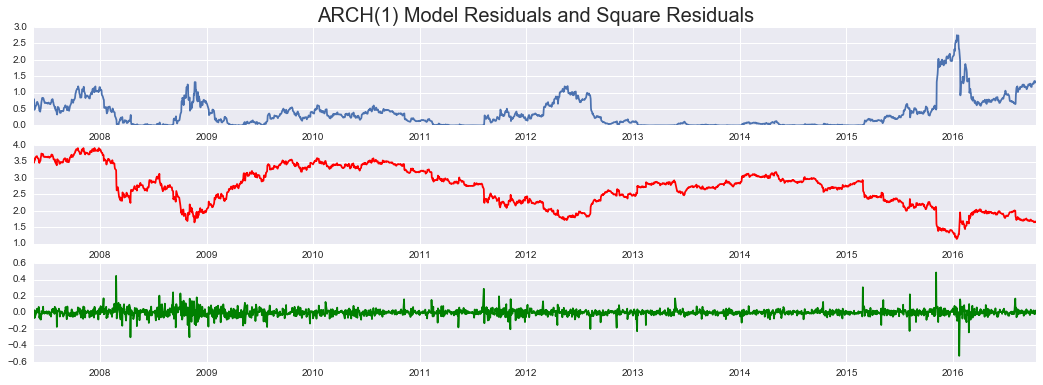

In [28]:
fig, ax = plt.subplots(figsize=(16,6))

plt.subplot(3, 1, 1)
plt.title('ARCH(1) Model Residuals and Square Residuals', size=20)
plt.plot(ENOC.date, ENOC['conditional_variances'])

plt.subplot(3, 1, 2)
plt.plot(ENOC.date, ENOC.logENOC, c='r')

plt.subplot(3, 1, 3)
plt.plot(ENOC.date, ENOC.diflogENOC, c='g')

In [29]:
ENOC['archresiduals'] = bestarchmod.resid
ENOC['bestarchmodel'] = ENOC.logENOC + ENOC.archresiduals
ENOC['bestarchmodelhigh'] = ENOC['bestarchmodel'] + bestarchmod.conf_int().iloc[2,0]
ENOC['bestarchmodellow'] = ENOC['bestarchmodel'] - bestarchmod.conf_int().iloc[2,1]

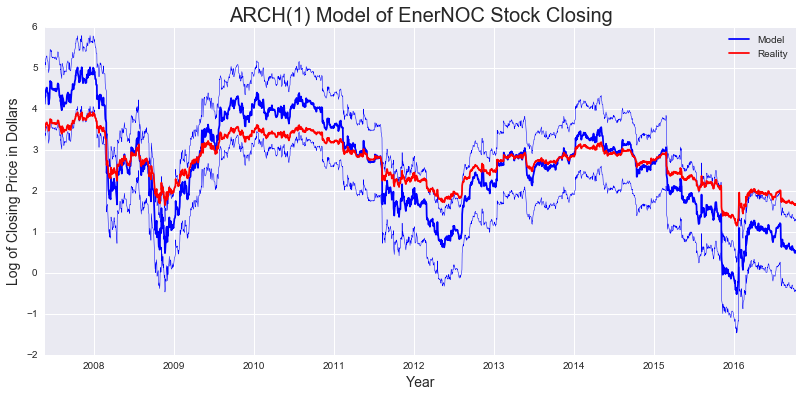

In [30]:
fig, ax = plt.subplots(figsize=(12,20))
plt.subplot(3, 1, 1)
plt.plot(ENOC.date, ENOC['bestarchmodel'], label='Model', c='b')
plt.plot(ENOC.date, ENOC['bestarchmodelhigh'], linewidth=.5, c='b', label='')
plt.plot(ENOC.date, ENOC['bestarchmodellow'], linewidth=.5, c='b', label='')
plt.plot(ENOC.date, ENOC['logENOC'], label='Reality', c='r')
plt.legend()
plt.title('ARCH(1) Model of EnerNOC Stock Closing', size=20)
plt.xlabel('Year', size=14)
plt.ylabel('Log of Closing Price in Dollars', size=14)

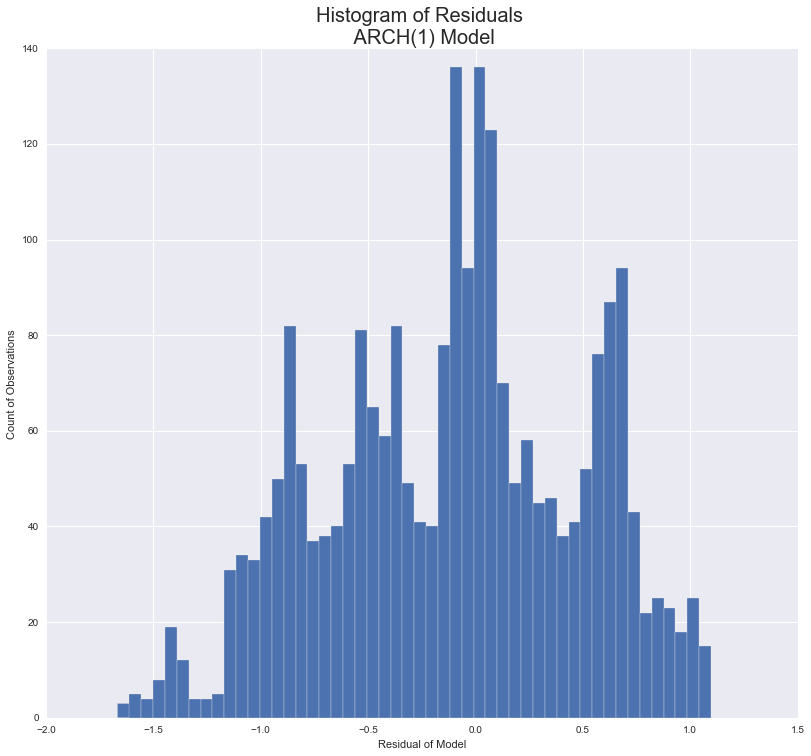

In [31]:
fig, ax = plt.subplots(figsize=(12,12))
ENOC.archresiduals.hist(bins = 50)
plt.title('Histogram of Residuals \n ARCH(1) Model', size = 20)
plt.xlabel('Residual of Model')
plt.ylabel('Count of Observations')

In [32]:
normaltest(np.asarray(ENOC.archresiduals))

NormaltestResult(statistic=126.61172628321565, pvalue=3.2107978646587098e-28)

In [33]:
ENOC['fail'] = ENOC['bestarchmodelhigh'] < ENOC['logENOC']
err = float(ENOC['fail'].sum())/len(ENOC)
print "Error %s " % str(err)

Error 0.168918918919 


- The worst moments of the stock collapse of 2015, was the model not able to keep up with reality. 
- It did a good job given the worse finical crisis of the last half century. 